In [32]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from keras import layers, models
from keras.models import Sequential
from keras.layers import Dense

import cv2
import pandas as pd
import dlib

In [96]:
for i in range(500):
    globals()['land'+str(i)] = pd.read_csv('./dlib500/train/%s.csv'%i)
    globals()['land'+str(i)] = np.array(globals()['land'+str(i)])
    
    tr_x = globals()['land'+str(i)][:, 0]
    tr_y = globals()['land'+str(i)][:, 1]
    
    tr_cx = ((min(tr_x)+max(tr_x)) / 2)        #dlib_rect 중점
    tr_cy = ((min(tr_y)+max(tr_y)) / 2)
    
    tr_h = max(tr_y)-min(tr_y)    #종축 길이
    
    tr_x -= tr_cx
    tr_y -= tr_cy
    
    norm_trx = (tr_x - min(tr_x)) / (tr_h * 1.5)
    norm_try = (tr_y - min(tr_y)) / (tr_h *1.5)
    
    globals()['train_norm'+str(i)] = np.column_stack((norm_trx, norm_try))

In [97]:
## eye, nose, mouth, jaws
for i in  range(500):
    globals()['norm_eye'+str(i)] = globals()['train_norm'+str(i)][36:48].flatten()
    globals()['norm_nose'+str(i)] = globals()['train_norm'+str(i)][27:36].flatten()
    globals()['norm_mouth'+str(i)] = globals()['train_norm'+str(i)][48:].flatten()
    globals()['norm_jaws'+str(i)] = globals()['train_norm'+str(i)][:17].flatten()

In [98]:
train_x = np.zeros((500, len(norm_eye0)))   #eye
for i in range(500):
    for j in range(len(norm_eye0)):
        train_x[i][j] = globals()['norm_eye'+str(i)][j]   

In [99]:
try_eye = pd.read_csv('./DataSet500/train/csv/train.csv')
try_eye = try_eye.iloc[:, 17]

In [100]:
for i in range(500):
    globals()['mark'+str(i)] = pd.read_csv('./dlib500/test/%s.csv'%i)
    globals()['mark'+str(i)] = np.array(globals()['mark'+str(i)])
    
    te_x = globals()['mark'+str(i)][:, 0]
    te_y = globals()['mark'+str(i)][:, 1]
    
    te_cx = ((min(te_x)+max(te_x)) / 2)
    te_cy = ((min(te_y)+max(te_y)) / 2)

    te_h = max(te_y)-min(te_y)
    
    
    te_x -= te_cx
    te_y -= te_cy

    norm_tex = (te_x - min(te_x)) / (te_h *1.5)
    norm_tey = (te_y - min(te_y)) / (te_h *1.5)
    
    globals()['test_norm'+str(i)] = np.column_stack((norm_tex, norm_tey))

In [101]:
## eye, nose, mouth, jaws
for i in  range(500):
    globals()['norm_eye2'+str(i)] = globals()['test_norm'+str(i)][36:48].flatten()
    globals()['norm_nose2'+str(i)] = globals()['test_norm'+str(i)][27:36].flatten()
    globals()['norm_mouth2'+str(i)] = globals()['test_norm'+str(i)][48:].flatten()
    globals()['norm_jaws2'+str(i)] = globals()['test_norm'+str(i)][:17].flatten()

In [102]:
test_x = np.zeros((500, len(norm_eye20)))
for i in range(500):
    for j in range(len(norm_eye20)):
        test_x[i][j] = globals()['norm_eye2'+str(i)][j]  

In [103]:
tey_eye = pd.read_csv('./DataSet500/test/csv/test.csv')
tey_eye = tey_eye.iloc[:, 17]

In [104]:
np.random.seed(1)
tf.random.set_seed(1)

learning_rate = 0.0005
N_EPOCHS = 500
N_BATCH = 32

In [105]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, try_eye))\
                                .shuffle(500)\
                                .batch(N_BATCH, drop_remainder=True)\
                                .repeat()
test_dataset = tf.data.Dataset.from_tensor_slices((test_x, tey_eye)).batch(N_BATCH)

In [106]:
def create_model():
    model = keras.Sequential()
    model.add(keras.layers.Dense(units=32, activation='relu', input_shape=(24,)))
    model.add(keras.layers.Dense(units=16, activation='relu'))
    model.add(keras.layers.Dense(units=8, activation='relu'))
    model.add(keras.layers.Dense(units=1))
    
    return model

In [107]:
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')

In [108]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 16)                400       
                                                                 
 dense_14 (Dense)            (None, 8)                 136       
                                                                 
 dense_15 (Dense)            (None, 4)                 36        
                                                                 
 dense_16 (Dense)            (None, 1)                 5         
                                                                 
Total params: 577
Trainable params: 577
Non-trainable params: 0
_________________________________________________________________


In [109]:
steps_per_epoch = train_x.shape[0]
validation_steps = int(np.ceil(test_x.shape[0]/N_BATCH))

In [110]:
from keras.callbacks import ReduceLROnPlateau
reduceLR = ReduceLROnPlateau(monitor='val_loss',
                            factor=0.5,
                            patience=10,
                            min_delta=0.0001,
                            cooldown=0,
                            min_lr=0,
                            mode='auto')

In [111]:
history = model.fit(train_dataset,
                   epochs=N_EPOCHS,
                   steps_per_epoch=steps_per_epoch,
                   validation_data = test_dataset,
                   validation_steps = validation_steps,
                   callbacks=[reduceLR])

Epoch 1/500
500/500 [==============================] - 1s 711us/step - loss: 0.0938 - val_loss: 0.0890 - lr: 5.0000e-04
Epoch 2/500
500/500 [==============================] - 0s 604us/step - loss: 0.0906 - val_loss: 0.0864 - lr: 5.0000e-04
Epoch 3/500
500/500 [==============================] - 0s 613us/step - loss: 0.0874 - val_loss: 0.0836 - lr: 5.0000e-04
Epoch 4/500
500/500 [==============================] - 0s 607us/step - loss: 0.0828 - val_loss: 0.0782 - lr: 5.0000e-04
Epoch 5/500
500/500 [==============================] - 0s 605us/step - loss: 0.0756 - val_loss: 0.0700 - lr: 5.0000e-04
Epoch 6/500
500/500 [==============================] - 0s 603us/step - loss: 0.0661 - val_loss: 0.0607 - lr: 5.0000e-04
Epoch 7/500
500/500 [==============================] - 0s 611us/step - loss: 0.0589 - val_loss: 0.0582 - lr: 5.0000e-04
Epoch 8/500
500/500 [==============================] - 0s 603us/step - loss: 0.0548 - val_loss: 0.0543 - lr: 5.0000e-04
Epoch 9/500
500/500 [===================

Epoch 69/500
500/500 [==============================] - 0s 603us/step - loss: 0.0417 - val_loss: 0.0515 - lr: 5.0000e-04
Epoch 70/500
500/500 [==============================] - 0s 599us/step - loss: 0.0424 - val_loss: 0.0505 - lr: 5.0000e-04
Epoch 71/500
500/500 [==============================] - 0s 607us/step - loss: 0.0415 - val_loss: 0.0439 - lr: 5.0000e-04
Epoch 72/500
500/500 [==============================] - 0s 607us/step - loss: 0.0425 - val_loss: 0.0436 - lr: 5.0000e-04
Epoch 73/500
500/500 [==============================] - 0s 615us/step - loss: 0.0417 - val_loss: 0.0436 - lr: 5.0000e-04
Epoch 74/500
500/500 [==============================] - 0s 613us/step - loss: 0.0412 - val_loss: 0.0439 - lr: 5.0000e-04
Epoch 75/500
500/500 [==============================] - 0s 611us/step - loss: 0.0416 - val_loss: 0.0438 - lr: 5.0000e-04
Epoch 76/500
500/500 [==============================] - 0s 617us/step - loss: 0.0412 - val_loss: 0.0438 - lr: 5.0000e-04
Epoch 77/500
500/500 [==========

500/500 [==============================] - 0s 603us/step - loss: 0.0370 - val_loss: 0.0419 - lr: 1.9531e-06
Epoch 204/500
500/500 [==============================] - 0s 607us/step - loss: 0.0369 - val_loss: 0.0419 - lr: 1.9531e-06
Epoch 205/500
500/500 [==============================] - 0s 607us/step - loss: 0.0370 - val_loss: 0.0419 - lr: 1.9531e-06
Epoch 206/500
500/500 [==============================] - 0s 605us/step - loss: 0.0369 - val_loss: 0.0418 - lr: 1.9531e-06
Epoch 207/500
500/500 [==============================] - 0s 603us/step - loss: 0.0370 - val_loss: 0.0419 - lr: 1.9531e-06
Epoch 208/500
500/500 [==============================] - 0s 625us/step - loss: 0.0369 - val_loss: 0.0419 - lr: 1.9531e-06
Epoch 209/500
500/500 [==============================] - 0s 613us/step - loss: 0.0369 - val_loss: 0.0419 - lr: 1.9531e-06
Epoch 210/500
500/500 [==============================] - 0s 611us/step - loss: 0.0367 - val_loss: 0.0419 - lr: 1.9531e-06
Epoch 211/500
500/500 [===============

500/500 [==============================] - 0s 617us/step - loss: 0.0370 - val_loss: 0.0418 - lr: 2.3842e-10
Epoch 338/500
500/500 [==============================] - 0s 643us/step - loss: 0.0369 - val_loss: 0.0418 - lr: 2.3842e-10
Epoch 339/500
500/500 [==============================] - 0s 647us/step - loss: 0.0370 - val_loss: 0.0418 - lr: 2.3842e-10
Epoch 340/500
500/500 [==============================] - 0s 611us/step - loss: 0.0369 - val_loss: 0.0418 - lr: 2.3842e-10
Epoch 341/500
500/500 [==============================] - 0s 623us/step - loss: 0.0369 - val_loss: 0.0418 - lr: 2.3842e-10
Epoch 342/500
500/500 [==============================] - 0s 619us/step - loss: 0.0369 - val_loss: 0.0418 - lr: 2.3842e-10
Epoch 343/500
500/500 [==============================] - 0s 611us/step - loss: 0.0370 - val_loss: 0.0418 - lr: 1.1921e-10
Epoch 344/500
500/500 [==============================] - 0s 607us/step - loss: 0.0370 - val_loss: 0.0418 - lr: 1.1921e-10
Epoch 345/500
500/500 [===============

500/500 [==============================] - 0s 601us/step - loss: 0.0370 - val_loss: 0.0418 - lr: 2.9104e-14
Epoch 472/500
500/500 [==============================] - 0s 605us/step - loss: 0.0371 - val_loss: 0.0418 - lr: 2.9104e-14
Epoch 473/500
500/500 [==============================] - 0s 605us/step - loss: 0.0368 - val_loss: 0.0418 - lr: 1.4552e-14
Epoch 474/500
500/500 [==============================] - 0s 605us/step - loss: 0.0369 - val_loss: 0.0418 - lr: 1.4552e-14
Epoch 475/500
500/500 [==============================] - 0s 605us/step - loss: 0.0370 - val_loss: 0.0418 - lr: 1.4552e-14
Epoch 476/500
500/500 [==============================] - 0s 603us/step - loss: 0.0368 - val_loss: 0.0418 - lr: 1.4552e-14
Epoch 477/500
500/500 [==============================] - 0s 599us/step - loss: 0.0368 - val_loss: 0.0418 - lr: 1.4552e-14
Epoch 478/500
500/500 [==============================] - 0s 605us/step - loss: 0.0369 - val_loss: 0.0418 - lr: 1.4552e-14
Epoch 479/500
500/500 [===============

In [112]:
model.evaluate(test_dataset)

history.history.keys()

16/16 [==============================] - 0s 533us/step - loss: 0.0418


dict_keys(['loss', 'val_loss', 'lr'])

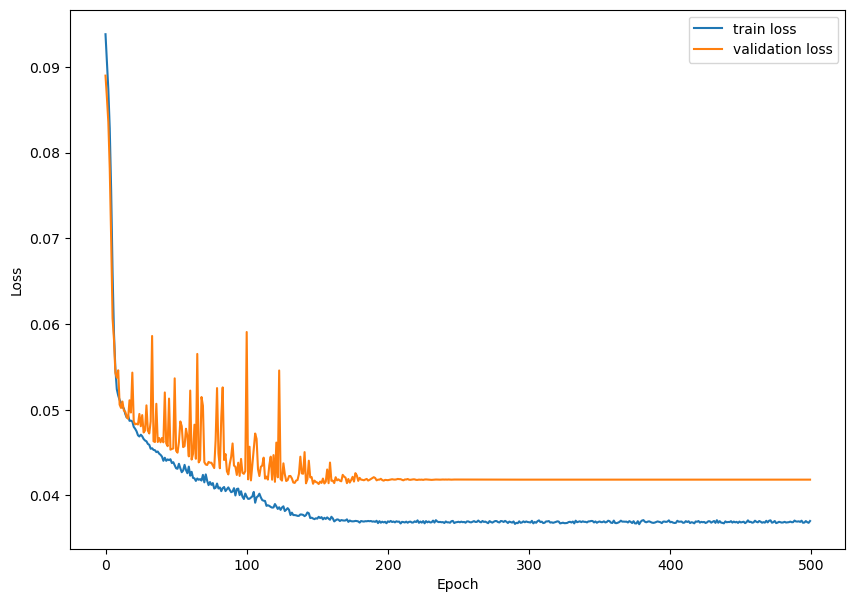

In [113]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.plot(range(N_EPOCHS), history.history['loss'], label='train loss')
plt.plot(range(N_EPOCHS), history.history['val_loss'], label='validation loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [114]:
pred = model.predict(test_x)
df = pd.DataFrame(pred)
df

16/16 [==============================] - 0s 533us/step


,0
0,0.256725
1,0.461360
2,0.801460
3,0.481665
4,0.478810
...,...
495,0.859937
496,0.744393
497,0.620236
498,0.379977


In [115]:
tey_eye

0      0.619949
1      0.136081
2      0.721543
3      0.587172
4      0.469172
         ...   
495    0.911575
496    0.349445
497    0.430166
498    0.271961
499    0.073425
Name: eyePosition, Length: 500, dtype: float64

In [116]:
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(tey_eye, pred)**0.5
print(rmse)

0.2045566128854046


In [117]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(tey_eye, pred)
print(mae)

0.1610204101461904
